In [61]:
# Import af nødvendige packages
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [62]:
""" SETTINGS """
source = 'csv' # quandl eller csv
data_interval = 'monthly' # daily, monthy eller yearly - Hvis Quandl = 'daily'
selected = ['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'HiTec', 'Telcm', 'Shops', 'Hlth', 'Utils', 'Other', 'Mkt'] # Angiv ønskede aktiver fra Quandl eller kolonner fra CSV-ark

# Hvis CVS:
file_name = '10 Industry Portfolios - Average Value Weighted Returns.CSV' # navn og file-exstention på data

# Hvis Quandl
date_range = ['2014-1-1', '2016-12-31'] # dato fra og med - dato til og med, format YYYY-MM-DD

In [63]:
# Træk af data fra Quandl
if source == 'quandl':
    quandl.ApiConfig.api_key = "yTPaspmH6wqs9rAdSdmk"
    data = quandl.get_table('WIKI/PRICES', ticker = selected, qopts = {'columns': ['date', 'ticker', 'adj_close']},
                            date = {'gte': date_range[0], 'lte': date_range[1]}, paginate=True)
    clean = data.set_index('date')
    table = clean.pivot(columns='ticker')
    returns_data = table.pct_change()
    
# Træk af data fra CSV-fil (allerede procent-vis ændring)
elif source == 'csv':
    rf = pd.read_csv(file_name, delimiter = ',', header = 0, usecols = ['RF'])
    data = pd.read_csv(file_name, delimiter = ',', header = 0, index_col = 'date', usecols = ['date'] + selected)
    returns_data = data

returns_data.head() # Eksempel på den procentvise ændring

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Mkt
date,,,,,,,,,,,
196307,-0.47,-0.22,-1.41,2.29,-0.69,-0.23,-1.03,0.56,0.80,-1.61,-0.12
196308,4.87,6.55,6.20,3.93,5.14,4.29,6.40,9.56,4.20,5.49,5.32
196309,-1.68,-0.24,-0.76,-3.64,0.13,2.36,0.96,-4.06,-2.50,-3.16,-1.30
196310,2.66,9.72,2.58,-0.32,8.29,3.40,0.48,3.38,-0.67,1.38,2.82
196311,-1.13,-4.84,0.30,-1.15,-0.29,4.16,-1.23,-1.65,-1.02,0.23,-0.58


In [64]:
if data_interval == 'monthly': # "1/N opgaven" tager udgangspunkt i månedlig data og sharpe
    returns_monthly = returns_data
    returns_mean = returns_monthly.mean()
    
    cov_matrix = returns_monthly.cov()
    
elif data_interval == 'daily': # primært brugt til data fra Quandl giver årlig sharpe
    returns_daily = returns_data
    returns_mean = returns_daily.mean() * 252
    
    cov_matrix = returns_daily.cov() * 252
    
cov_matrix # Covariance-matricen

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Mkt
NoDur,20.118390,17.569970,18.011453,11.413690,17.059092,12.129320,20.515379,17.417159,11.225120,19.746574,16.722334
Durbl,17.569970,32.552825,22.852590,13.296257,25.833256,14.634323,23.921012,15.583820,10.315727,23.058290,20.429179
Manuf,18.011453,22.852590,23.491802,15.058546,24.836875,13.153174,22.062570,17.703630,10.221934,22.630332,20.182440
Enrgy,11.413690,13.296257,15.058546,26.864954,14.861933,9.014859,12.267891,11.490506,11.774041,16.098782,15.118991
HiTec,17.059092,25.833256,24.836875,14.861933,45.783280,18.374949,25.432022,20.720012,7.458230,24.664040,25.693063
Telcm,12.129320,14.634323,13.153174,9.014859,18.374949,21.809255,15.328871,12.037994,9.068982,15.370718,14.900700
Shops,20.515379,23.921012,22.062570,12.267891,25.432022,15.328871,29.376201,18.436433,10.360400,23.665507,20.910786
Hlth,17.417159,15.583820,17.703630,11.490506,20.720012,12.037994,18.436433,25.934086,9.588104,19.001598,17.400926
Utils,11.225120,10.315727,10.221934,11.774041,7.458230,9.068982,10.360400,9.588104,16.710548,13.009581,10.549706
Other,19.746574,23.058290,22.630332,16.098782,24.664040,15.370718,23.665507,19.001598,13.009581,27.204552,21.583400


In [65]:
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

In [66]:
num_assets = len(selected)
num_portfolios = 500000

In [67]:
# laver et seed så resultater kan reproduceres
np.random.seed(101)

# simulerer 50000 (num_portfolios) portføljer med tilfældig vægt
for single_portfolio in range(num_portfolios):
    
    # Giver tilfældig vægt til de valgte akriver, normaliserer så sum(vægt) = 1
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    # udregner profit, volatilitet og sharpe NB: det risikofrie aktiver er 0% i dette tilfælde
    returns = np.dot(weights, returns_mean)  - float(rf.mean())
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = returns / volatility

    # indsætter overstående udregninger i vektorerne
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

In [68]:
# definerer portfolier som en sammensætning af overstående udregninger
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

In [69]:
# definerer de enkelte vægte af de valgte aktiver
for i in range(len((selected))):
    symbol = selected[i]
    portfolio[symbol+' Weight'] = [Weight[i] for Weight in stock_weights]

In [70]:
# sætter vores portføljer som dataframe i pandas
df = pd.DataFrame(portfolio)
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [symbol+' Weight' for symbol in selected]
df = df[column_order]

df.head() # Eksempel på de tilfældigt genereret porteføljer

,Returns,Volatility,Sharpe Ratio,NoDur Weight,Durbl Weight,Manuf Weight,Enrgy Weight,HiTec Weight,Telcm Weight,Shops Weight,Hlth Weight,Utils Weight,Other Weight,Mkt Weight
0,0.511593,4.109178,0.124500,0.094362,0.104279,0.005203,0.031342,0.125221,0.152379,0.056092,0.163291,0.131848,0.034708,0.101275
1,0.560887,4.259941,0.131665,0.065053,0.033603,0.145133,0.178365,0.042925,0.015437,0.111500,0.134675,0.051033,0.126604,0.095671
2,0.526808,4.071936,0.129375,0.008263,0.023495,0.031862,0.169449,0.088730,0.098636,0.125226,0.092360,0.155617,0.137684,0.068678
3,0.528204,4.460974,0.118406,0.054111,0.144338,0.052052,0.131042,0.125767,0.081518,0.139732,0.014715,0.015579,0.106261,0.134886
4,0.533815,4.516615,0.118189,0.035413,0.061161,0.149254,0.036466,0.155663,0.108226,0.151070,0.115753,0.009632,0.049701,0.127662


In [71]:
# finder min vol og max sharp værdier
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

In [72]:
# finder portføljerne der stemmer overens med overstående værdier
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
minvar_portfolio = df.loc[df['Volatility'] == min_volatility]

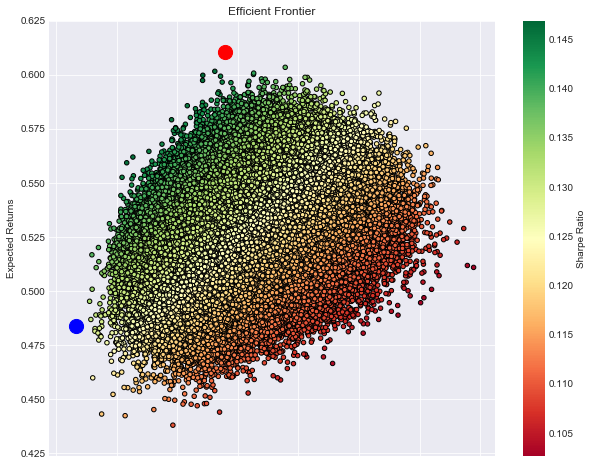

In [73]:
# plotter hele lortet
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='o', s=200)
plt.scatter(x=minvar_portfolio['Volatility'], y=minvar_portfolio['Returns'], c='blue', marker='o', s=200)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [74]:
sharpe_portfolio

,Returns,Volatility,Sharpe Ratio,NoDur Weight,Durbl Weight,Manuf Weight,Enrgy Weight,HiTec Weight,Telcm Weight,Shops Weight,Hlth Weight,Utils Weight,Other Weight,Mkt Weight
303594,0.610559,4.15744,0.146859,0.259029,0.001119,0.084182,0.278087,0.069501,0.005428,0.001645,0.249464,0.005868,0.014164,0.031512


In [75]:
minvar_portfolio

,Returns,Volatility,Sharpe Ratio,NoDur Weight,Durbl Weight,Manuf Weight,Enrgy Weight,HiTec Weight,Telcm Weight,Shops Weight,Hlth Weight,Utils Weight,Other Weight,Mkt Weight
406390,0.484012,3.666274,0.132017,0.06475,0.06272,0.017859,0.209104,0.00014,0.235505,0.01797,0.09254,0.276879,0.012091,0.010441
